In [180]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_dir="/content/gdrive/My Drive/Colab Files/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import copy
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as Variable

import torchvision
import torchvision.transforms as transforms

In [2]:
torch.set_printoptions(edgeitems=3, linewidth=200)
def print_net(model):
  for layer in model.parameters():
    print(layer.data)
  print()
def net_sparsity(model, threshold=10**-6):
  all_params = torch.cat([x.view(-1) for x in model.parameters()])
  n_zeros = torch.sum(1.0*(torch.abs(all_params) < threshold)).item()
  total = torch.sum(1.0*(torch.abs(all_params) > -1)).item()
  return((n_zeros, total))

## Define architecture and circuit function

In [6]:
input_dim = 32

class JNet(nn.Module):
    def __init__(self):
        super(JNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 80, bias=True),
            nn.ReLU(),
            nn.Linear(80, 60, bias=True),
            nn.ReLU(),
            nn.Linear(60, 40, bias=True),
            nn.ReLU(),
            nn.Linear(40, 20, bias=True),
            nn.ReLU(),
            nn.Linear(20, 10, bias=True),
            nn.ReLU(),
            nn.Linear(10, 10, bias=True),
            nn.ReLU(),
            nn.Linear(10, 1, bias=True)
        )

    def forward(self, x):
        x.view(x.size(0), -1)
        x = self.net(x)
        return x

In [7]:
def f_discrete(x, n_gates_left):
  layer_len = round(len(x[0])/2)

  while n_gates_left >= layer_len and layer_len > 0:
    # print(x, n_gates_left, layer_len)
    x = torch.sum(x.view(len(x), -1, 2), axis=2)%2
    n_gates_left -= layer_len
    layer_len = round(layer_len/2)

  if layer_len > 0:
    x = torch.sum(x.view(len(x), -1, 2), axis=2)
    x[:, 0:n_gates_left] %= 2
  return(torch.sum(x, axis=1))


def f(x, a):
  a *= (len(x[0]) - 1)
  a0 = int(a)
  w0 = (1 - (a - a0))
  a1 = int(a) + 1
  w1 = (a - a0)

  if w1 == 0:
    return(w0*f_discrete(x, a0))

  return(w0*f_discrete(x, a0) + w1*f_discrete(x, a1))

# def f(x, a):
  # return(torch.tensor([f_on_vec(row, a) for row in x]))

q = torch.tensor([[1, 1, 0, 1, 1, 0, 1, 0], [1, 0, 0, 0, 0, 1, 0, 1]])
f(q, 5.1/7)

tensor([2.8000, 2.8000])

## Optimize on initial circuit

In [8]:
model = JNet()

# setup optimization
loss_fn = nn.MSELoss()
# model.optimizer = optim.SGD(model.parameters(), lr=.000001, momentum=.999)
model.optimizer = optim.Adam(model.parameters(), lr=.001)

batch_size = 100
n_epochs = 50000

last_t = time.time() - 9999999
for epoch in range(n_epochs):
  model.optimizer.zero_grad()

  xs = (torch.randn(batch_size, input_dim) > 0)*1.
  ys = f(xs, 0)
  ys_m = model(xs).view(-1)

  loss = loss_fn(ys, ys_m)
  loss.backward()
  
  model.optimizer.step()

  if time.time() - last_t > 2:
    print(epoch, "%.10f" % loss.item())
    last_t = time.time()

0 248.4181823730
955 0.0004015791
1989 0.0002306597
2991 0.0001158699
4006 0.0001653427
5020 0.0000791673
6057 0.0001516737
7088 0.0000740324
8121 0.0030176030
9141 0.0000226759
10159 0.0000986766
11187 0.0001135366
12201 0.0000539204
13219 0.0013249741
14226 0.0000033235
15243 0.0003903415
16248 0.0000107209
17254 0.0000517694
18281 0.0000347399
19287 0.0001470675
20288 0.0006520452
21283 0.0000028355
22262 0.0000045904
23230 0.0000173038
24238 0.0000016313
25218 0.0077872858
26212 0.0001373502
27207 0.0000391974
28219 0.0000046124
29231 0.0066687791
30228 0.0033028945
31245 0.0000177505
32239 0.0011770693
33230 0.0000040593
34228 0.0024752673
35247 0.0001729654
36224 0.0001216179
37197 0.0002500428
38200 0.0001348207
39228 0.0001541208
40258 0.0006622258
41288 0.0000929132
42293 0.0001349903
43290 0.0021862409
44303 0.0000062617
45332 0.0000741110
46359 0.0000016426
47402 0.0000012181
48447 0.0002088826
49475 0.0000259323


In [9]:
model_copy = copy.deepcopy(model)

## Gradually grow circuit while optimizing

In [11]:
batch_size = 50
n_epochs = 1000000

# model.optimizer = optim.SGD(model.parameters(), lr=.0002, momentum=.99)
model.optimizer = optim.Adam(model.parameters(), lr=.001)

for epoch in range(n_epochs):
  model.optimizer.zero_grad()

  a = 1.0*(epoch/n_epochs)

  xs = (torch.randn(batch_size, input_dim) > 0)*1.
  ys = f(xs, a)
  ys_m = model(xs).view(-1)

  loss = loss_fn(ys, ys_m)
  loss.backward()
  
  model.optimizer.step()

  if int(input_dim*epoch/n_epochs) - int(input_dim*(epoch - 1)/n_epochs) == 1:
    print('*'*101)
  if time.time() - last_t > 2:
    print(epoch, "%.5f" % a, "%.10f" % loss.item())
    last_t = time.time()

0 0.00000 0.0000153847
1074 0.00107 0.0002625896
2163 0.00216 0.0015254599
3258 0.00326 0.0001031461
4338 0.00434 0.0007463659
5393 0.00539 0.0002186221
6453 0.00645 0.0000625198
7528 0.00753 0.0000706816
8606 0.00861 0.0006226705
9694 0.00969 0.0001025095
10778 0.01078 0.0003520010
11854 0.01185 0.0000427420
12926 0.01293 0.0003161234
14005 0.01401 0.0004406834
15085 0.01508 0.0003327408
16164 0.01616 0.0000907973
17240 0.01724 0.0003231296
18320 0.01832 0.0000155576
19394 0.01939 0.0000953890
20463 0.02046 0.0001974127
21526 0.02153 0.0002206808
22590 0.02259 0.0000879871
23656 0.02366 0.0000565716
24719 0.02472 0.0011236409
25783 0.02578 0.0001142659
26845 0.02685 0.0002694136
27907 0.02791 0.0014492609
28928 0.02893 0.0018649944
29977 0.02998 0.0003627714
31031 0.03103 0.0037904272
*****************************************************************************************************
32079 0.03208 0.0000271369
33134 0.03313 0.0014978431
34171 0.03417 0.0018012096
35221 0.03522 0.0039

276404 0.27640 0.0000995156
277402 0.27740 0.0002159597
278399 0.27840 0.0004591617
279403 0.27940 0.0039648353
280393 0.28039 0.0006101192
*****************************************************************************************************
281385 0.28138 0.0005482394
282377 0.28238 0.0003354540
283365 0.28336 0.0000546808
284357 0.28436 0.0001973122
285347 0.28535 0.0003790402
286343 0.28634 0.0002543673
287334 0.28733 0.0002195646
288328 0.28833 0.0001944360
289319 0.28932 0.0033037462
290307 0.29031 0.0002881379
291294 0.29129 0.0004738775
292283 0.29228 0.0015432410
293268 0.29327 0.0001585073
294256 0.29426 0.0007305574
295244 0.29524 0.0005430860
296235 0.29624 0.0002291314
297220 0.29722 0.0002881127
298194 0.29819 0.0002275132
299173 0.29917 0.0003245829
300153 0.30015 0.0000918785
301142 0.30114 0.0001831065
302125 0.30212 0.0002010775
303110 0.30311 0.0002788061
304100 0.30410 0.0006004462
305090 0.30509 0.0022662648
306075 0.30607 0.0002472825
307061 0.30706 0.0007286642
30

532301 0.53230 0.0001338936
533259 0.53326 0.0002265596
534217 0.53422 0.0000774780
535183 0.53518 0.0002297766
536125 0.53612 0.0002061656
537080 0.53708 0.0003469549
538042 0.53804 0.0001534730
538988 0.53899 0.0000816479
539948 0.53995 0.0004657231
540901 0.54090 0.0006124434
541852 0.54185 0.0004980995
542810 0.54281 0.0004194654
543767 0.54377 0.0003274541
544737 0.54474 0.0001713925
545697 0.54570 0.0010733274
546657 0.54666 0.0033316019
547619 0.54762 0.0004082002
548575 0.54858 0.0003128363
549535 0.54953 0.0038601391
550482 0.55048 0.0032972253
551438 0.55144 0.0050303228
552387 0.55239 0.0052756937
553341 0.55334 0.0026485859
554293 0.55429 0.0032411462
555246 0.55525 0.0006375622
556194 0.55619 0.0007463419
557149 0.55715 0.0003739047
558106 0.55811 0.0010162280
559061 0.55906 0.0008222475
560011 0.56001 0.0004263658
560969 0.56097 0.0003528858
561924 0.56192 0.0019723121
*****************************************************************************************************
56

782830 0.78283 0.0041494076
783774 0.78377 0.0024250539
784717 0.78472 0.0024909806
785655 0.78565 0.0037603802
786585 0.78658 0.0085933506
787502 0.78750 0.0036309999
788411 0.78841 0.0021770538
789301 0.78930 0.0033491456
790230 0.79023 0.0037633721
791171 0.79117 0.0042505655
792109 0.79211 0.0008235052
793052 0.79305 0.0023530801
793986 0.79399 0.0029353267
794929 0.79493 0.0011809908
795869 0.79587 0.0266613085
796807 0.79681 0.0006604770
797749 0.79775 0.0025990424
798693 0.79869 0.0098691937
799633 0.79963 0.0167619232
800572 0.80057 0.0043817838
801514 0.80151 0.0045051463
802460 0.80246 0.0030022825
803401 0.80340 0.0009201478
804351 0.80435 0.0058607613
805297 0.80530 0.0013078833
806230 0.80623 0.0010219758
807167 0.80717 0.0042520459
808111 0.80811 0.0044752043
809050 0.80905 0.0055097300
809991 0.80999 0.0086833257
810931 0.81093 0.0235898755
811870 0.81187 0.0118082594
*****************************************************************************************************
81

In [15]:
model_copy_2 = copy.deepcopy(model)

In [17]:
model = copy.deepcopy(model_copy_2)

## Optimize on final circuit

In [39]:
batch_size = 1000
n_epochs = 100000

model.optimizer = optim.Adam(model.parameters(), lr=.0001)

for epoch in range(n_epochs):
  model.optimizer.zero_grad()

  a = 1.0

  xs = (torch.randn(batch_size, input_dim) > 0)*1.
  ys = f(xs, a)
  ys_m = model(xs).view(-1)

  loss = loss_fn(ys, ys_m)
  loss.backward()
  
  model.optimizer.step()

  if time.time() - last_t > 2:
    print(epoch, "%.5f" % a, "%.10f" % loss.item())
    last_t = time.time()

0 1.00000 0.0000115397
649 1.00000 0.0000085174


KeyboardInterrupt: 

In [184]:
pickle.dump(model, open(drive_dir + "parity_solvers/40bits_80width_circuit.p", "wb" ))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [40]:
xs = (torch.randn(10000, input_dim) > 0)*1.

print(torch.mean((torch.abs(model(xs).view(-1) - f(xs, 1).view(-1)) < .5) + 0.))

tensor(1.)


## Optimize for sparsity

In [41]:
sparsified_model = copy.deepcopy(model)

batch_size = 100
n_epochs = 100000
lambda1 = .00001

# model.optimizer = optim.SGD(model.parameters(), lr=.00001, momentum=.99)
sparsified_model.optimizer = optim.Adam(sparsified_model.parameters(), lr=.0001)

for epoch in range(n_epochs):
  sparsified_model.optimizer.zero_grad()

  a = 1

  xs = (torch.randn(batch_size, input_dim) > 0)*1.
  ys = f(xs, a)
  ys_m = sparsified_model(xs).view(-1)

  model_params = torch.cat([x.view(-1) for x in sparsified_model.parameters()])
  l1_cost = lambda1 * torch.norm(model_params, 1)

  loss = loss_fn(ys, ys_m) + l1_cost
  loss.backward()
  
  sparsified_model.optimizer.step()

  if time.time() - last_t > 2:
    print(epoch, "%.5f" % a, "%.10f" % loss.item())
    last_t = time.time()

0 1.00000 0.0249389224
857 1.00000 0.0203437209
1728 1.00000 0.0181711316
2595 1.00000 0.0169804990
3463 1.00000 0.0160951652
4330 1.00000 0.0153526384
5196 1.00000 0.0147385467
6064 1.00000 0.0141986990
6929 1.00000 0.0137294894
7796 1.00000 0.0133278854
8665 1.00000 0.0130184190
9530 1.00000 0.0126908217
10401 1.00000 0.0124460971
11269 1.00000 0.0121814422
12136 1.00000 0.0119833611
13003 1.00000 0.0117860436
13870 1.00000 0.0115928408
14690 1.00000 0.0114225401
15510 1.00000 0.0113027068
16378 1.00000 0.0111524388
17243 1.00000 0.0109990202
18111 1.00000 0.0109151611
18976 1.00000 0.0107752131
19842 1.00000 0.0106622586
20713 1.00000 0.0105463294
21583 1.00000 0.0104613267
22452 1.00000 0.0103732888
23284 1.00000 0.0102900527
24097 1.00000 0.0102276299
24954 1.00000 0.0101546105
25813 1.00000 0.0100746769
26677 1.00000 0.0100129955
27538 1.00000 0.0099371821
28396 1.00000 0.0098702852
29258 1.00000 0.0098323422
30117 1.00000 0.0097464100
30976 1.00000 0.0096994648
31837 1.00000 0.0

KeyboardInterrupt: 

In [57]:
threshold = 10**-2

for p in sparsified_model.parameters():
  with torch.no_grad():
    p *= 1.0*(torch.abs(p) > threshold)

# test accuracy
xs = (torch.randn(300, input_dim) > 0)*1.
print("model: " + str(torch.mean((torch.abs(model(xs).view(-1) - f(xs, 1).view(-1)) < .5) + 0.).item()))
print("sparsified model: " + str(torch.mean((torch.abs(sparsified_model(xs).view(-1) - f(xs, 1).view(-1)) < .5) + 0.).item()))

# test sparsity
print(net_sparsity(model, threshold))
print(net_sparsity(sparsified_model, threshold))

model: 1.0
sparsified model: 1.0
(1292.0, 11091.0)
(9132.0, 11091.0)


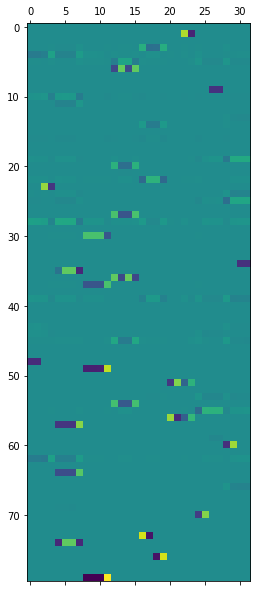

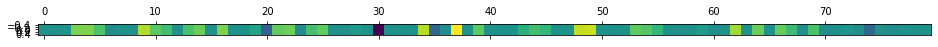

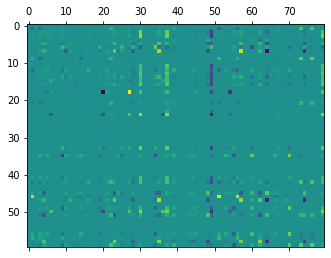

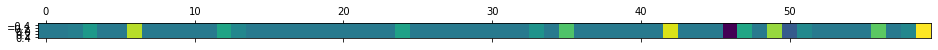

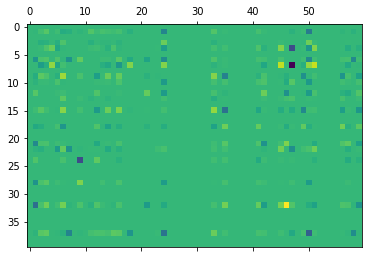

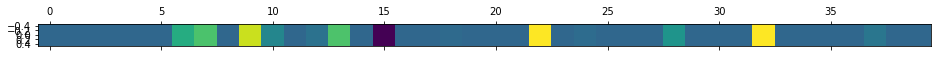

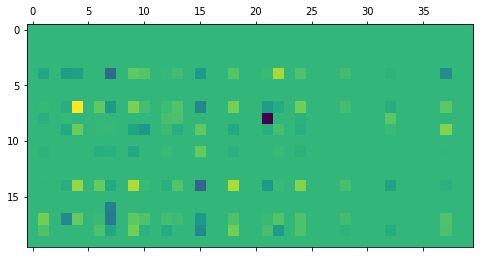

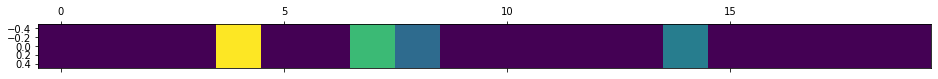

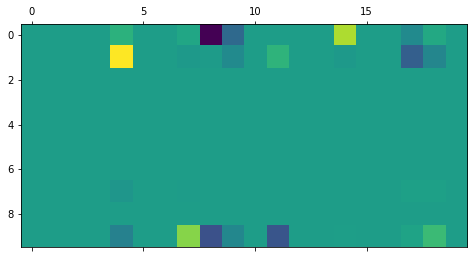

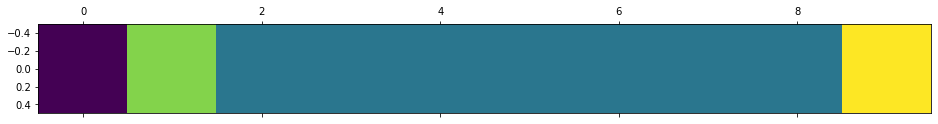

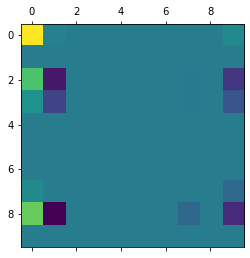

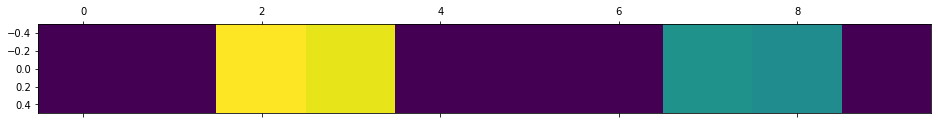

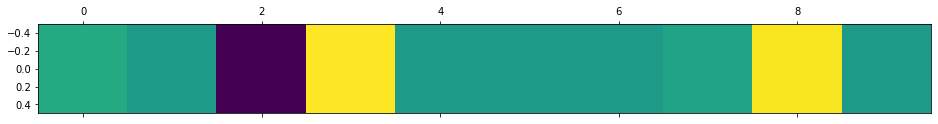

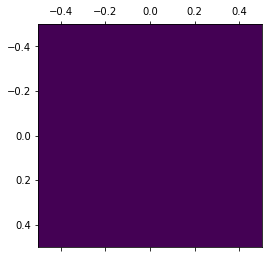

In [46]:
# sparsified_model = model

plt.matshow(sparsified_model.net[0].weight.detach().numpy())
plt.matshow([sparsified_model.net[0].bias.detach().numpy()])
plt.matshow(sparsified_model.net[2].weight.detach().numpy())
plt.matshow([sparsified_model.net[2].bias.detach().numpy()])
plt.matshow(sparsified_model.net[4].weight.detach().numpy())
plt.matshow([sparsified_model.net[4].bias.detach().numpy()])
plt.matshow(sparsified_model.net[6].weight.detach().numpy())
plt.matshow([sparsified_model.net[6].bias.detach().numpy()])
plt.matshow(sparsified_model.net[8].weight.detach().numpy())
plt.matshow([sparsified_model.net[8].bias.detach().numpy()])
plt.matshow(sparsified_model.net[10].weight.detach().numpy())
plt.matshow([sparsified_model.net[10].bias.detach().numpy()])
plt.matshow(sparsified_model.net[12].weight.detach().numpy())
plt.matshow([sparsified_model.net[12].bias.detach().numpy()])

In [63]:
print(sparsified_model.net[0].weight.data.tolist()[6])
print(sparsified_model.net[0].bias.data.tolist()[6])

[-0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -1.7957812547683716, 1.8605979681015015, -1.730863332748413, 1.7971177101135254, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0]
-0.13175711035728455


## AND/NAND circuit math

762999


(array([86354., 37827., 31463., 25566., 22197., 19293., 16396., 16162.,
        14785., 14202., 13392., 12409., 11270., 10574., 10835., 10416.,
         9525.,  9359.,  8879.,  8636.,  8071.,  8355.,  8042.,  7790.,
         7157.,  6962.,  6856.,  6934.,  6761.,  6652.,  6718.,  6658.,
         6239.,  6430.,  6159.,  5853.,  5533.,  5696.,  5642.,  5345.,
         5382.,  5329.,  5520.,  5556.,  5316.,  5100.,  4948.,  5022.,
         4904.,  4931.,  4649.,  4758.,  4695.,  4618.,  4673.,  4636.,
         4311.,  4237.,  4155.,  4190.,  4248.,  4129.,  4189.,  4199.,
         4283.,  4165.,  4018.,  3994.,  3923.,  3876.,  3674.,  3744.,
         3679.,  3741.,  3740.,  4018.,  3783.,  3740.,  3517.,  3714.,
         3605.,  3773.,  3582.,  3600.,  3672.,  3368.,  3495.,  3478.,
         3585.,  3530.,  3102.,  3396.,  2965.,  3218.,  3347.,  2980.,
         2975.,  2546.,  2312.,  1773.]),
 array([2.32830644e-10, 9.99969506e-03, 1.99993899e-02, 2.99990847e-02,
        3.99987795e-02

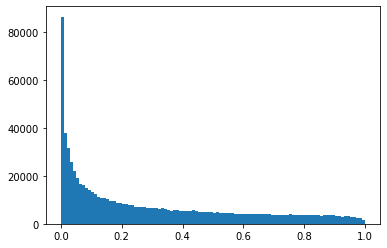

In [11]:
ps = {1/2}

for i in range(5):
  ps_new = set()
  for p1 in ps:
    for p2 in ps:
      ps_new.add(p1*p2)
      ps_new.add(p1*(1 - p2))
      ps_new.add((1 - p1)*p2)
      ps_new.add((1 - p1)*(1 - p2))
  
  ps = sorted(ps_new)

print(len(ps))
plt.hist(ps, bins=100)

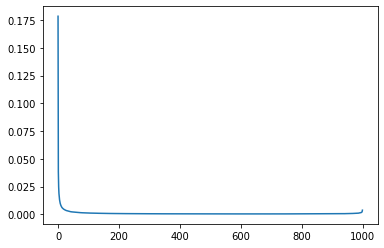

In [34]:
# simulating probabilities of final gate activation probabilities in a random binary tree circuit where each node's and AND with its two inputs each either NOTted or not

n_bins = 10**3

ps = [0 for i in range(n_bins)]
ps[round(n_bins/2)] = 1

for layer in range(7):
  ps_new = [0 for i in range(n_bins)]
  for i in range(n_bins):
    for j in range(n_bins):
      z = ((i + .5)/n_bins)*((j + .5)/n_bins)
      ps_new[int(z*n_bins)] += ps[i]*ps[j]/4

      z = ((i + .5)/n_bins)*(1 - (j + .5)/n_bins)
      ps_new[int(z*n_bins)] += ps[i]*ps[j]/4

      z = (1 - (i + .5)/n_bins)*((j + .5)/n_bins)
      ps_new[int(z*n_bins)] += ps[i]*ps[j]/4

      z = (1 - (i + .5)/n_bins)*(1 - (j + .5)/n_bins)
      ps_new[int(z*n_bins)] += ps[i]*ps[j]/4
  ps = ps_new

plt.plot(ps_new)